## Feature Estimation & PCA Analysis 
- This notebook is used to estimate the features of the neurons and perform PCA analysis. 
- Place Field Features: 
    - Peak Rate 
    - Average Rate
    - Place Field Width
    - Place Field Peak Location
    - Number of Place Fields
    - Percentage of Trials Close to Peak
    - Presence Ratio
- PCA Analysis: 
    - Perform PCA on the features
    - Plot the explained variance
    - Plot the PCA scores
    - Plot the PCA loadings






In [1]:
%matplotlib inline
# Import standard data science libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from convnwb.io import get_files, load_jsons_to_df
from scipy.stats import binom_test
from spiketools.plts.utils import make_grid, get_grid_subplot, save_figure
from spiketools.plts.style import drop_spines
from spiketools.utils.run import create_methods_list

In [2]:
import seaborn as sns
sns.set_context('talk', font_scale=0.9)

In [3]:
import sys
sys.path.append('../code')
from utils import find_place_field,find_place_location,even_odd_correlation

sys.path.append('../scripts')
from settings import PATHS, METHODS

In [4]:
results_folder = PATHS['RESULTS'] / 'units'
reports_folder = PATHS['REPORTS'] / 'units'


In [5]:
locations_folder = PATHS['BASE'] / 'localization'/'Loc'
locations_files = get_files(locations_folder, select='session_data')
Locations = load_jsons_to_df(locations_files, folder=locations_folder)


In [6]:
# Get the list of files
res_files = get_files(results_folder, select='mat')

In [7]:
# Collect all unit results together into a dataframe
all_results = load_jsons_to_df(res_files, folder=results_folder)

In [8]:
# Get total number of units
n_units = len(all_results)
print('Total number of cells: {}'.format(n_units))
# Collect numbers of significant cells
analyses = create_methods_list(METHODS)
# Statistics settings
alpha_level = 0.05
binom_sidedness = 'greater'   
results = {}
for analysis in analyses:
    all_results[f'is_{analysis}'] = (all_results[f'{analysis}_surr_p_val'] < alpha_level).values

for analysis in analyses:
     results[analysis] = sum(all_results['is_' + analysis])


# Compute significance of the counts of detected neurons
all_stats = {}
for analysis in analyses:
    all_stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)

Total number of cells: 390


/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_95772/3223072776.py:20: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  all_stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)


In [9]:
# Check the number & percent of significant cells per analysis
print('total cells: {}\n'.format( n_units))
for analysis in analyses:
    print('# {} cells:     \t\t{:3d}  ({:5.2f}%) \t\t {:.4f}'.format(\
        analysis, results[analysis], results[analysis] / n_units * 100, all_stats[analysis]))

total cells: 390

# place_anova cells:     		 85  (21.79%) 		 0.0000
# place_info cells:     		 84  (21.54%) 		 0.0000
# place_fr_anova cells:     		 54  (13.85%) 		 0.0000
# place_fr_info cells:     		 63  (16.15%) 		 0.0000


In [10]:
spike_names = all_results['spike_name']
labels = all_results['label']

In [11]:
all_results['channel'] = spike_names.str.extract(r'(?:NSX|CSC)(\d+)')[0].str.lstrip('0')
all_results['sessions'] = all_results['session_id'].str.extract(r'(\w+)_(\d+)_train_events.mat')[0] + '_' + all_results['session_id'].str.extract(r'(\w+)_(\d+)_train_events.mat')[1]


In [12]:
all_results.columns

Index(['unit_ind', 'session_id', 'label', 'spike_name', 'place_bins',
       'spike_position', 'trial_changes', 'trial_Num', 'trial_place_bins',
       'place_sem', 'trial_fr', 'fr_bins', 'fr_sem', 's_bins', 'place_info',
       'place_fr_info', 'place_anova', 'place_fr_anova',
       'place_anova_surr_p_val', 'place_anova_surr_z_score',
       'place_info_surr_p_val', 'place_info_surr_z_score',
       'place_fr_anova_surr_p_val', 'place_fr_anova_surr_z_score',
       'place_fr_info_surr_p_val', 'place_fr_info_surr_z_score',
       'is_place_anova', 'is_place_info', 'is_place_fr_anova',
       'is_place_fr_info', 'channel', 'sessions'],
      dtype='object')

In [13]:
fr_bins = all_results['fr_bins']
fr_bins 

0      [11.097516632672882, 11.080357142857142, 11.79...
1      [0.48277980699855705, 0.5859375, 1.14360119047...
2      [1.1842697233322235, 1.2777157738095235, 1.050...
3      [0.21374458874458874, 0.42782738095238093, 0.6...
4      [6.532778853091354, 7.319010416666667, 8.01041...
                             ...                        
385    [0.860953282828283, 1.0026041666666665, 0.5598...
386    [6.895523313492065, 7.1789434523809526, 7.2574...
387    [13.79444557178932, 13.749627976190471, 15.441...
388    [10.084128111471863, 10.440848214285714, 8.933...
389    [0.9018928120490619, 1.0729166666666667, 1.435...
Name: fr_bins, Length: 390, dtype: object

## Get Features 

In [14]:
## Compute Features
# Initialize new columns with appropriate data types
all_results['peak_rate'] = np.nan
all_results['average_rate'] = np.nan
all_results['SNR'] = np.nan
all_results['place_field_bins'] = pd.Series([None] * len(all_results))
all_results['noise_bins'] = pd.Series([None] * len(all_results))
all_results['labeled_fields'] = pd.Series([None] * len(all_results))
all_results['N_place_fields'] = pd.Series([None] * len(all_results))
all_results['place_field_peak_location'] = pd.Series([None] * len(all_results))
all_results['trial_peak_loc'] = pd.Series([None] * len(all_results))
all_results['trial_peak_rate'] = pd.Series([None] * len(all_results))
all_results['num_trials_close_to_peak'] = pd.Series([None] * len(all_results))
all_results['percentage_num_trials_close_to_peak'] = pd.Series([None] * len(all_results))

# Calculate basic rate features
all_results['peak_rate'] = all_results['fr_bins'].apply(np.max)
all_results['average_rate'] = all_results['fr_bins'].apply(np.mean)
all_results['SNR'] = all_results['peak_rate'] / all_results['average_rate']

# Calculate place field features for each unit
for i in range(len(all_results)):
    # Forward direction analysis
    (all_results.at[i,'place_field_bins'], 
     all_results.at[i,'noise_bins'],
     all_results.at[i,'labeled_fields'], 
     all_results.at[i,'N_place_fields'],
     all_results.at[i,'peak_rate'],
     all_results.at[i,'place_field_peak_location']) = find_place_field(all_results['fr_bins'][i])

    (all_results.at[i,'trial_peak_loc'],
     all_results.at[i,'trial_peak_rate'], 
     all_results.at[i,'num_trials_close_to_peak'],
     all_results.at[i,'percentage_num_trials_close_to_peak']) = find_place_location(all_results['trial_fr'][i], 
                                                                                   all_results['place_field_peak_location'][i],tolerance = 6)



In [15]:
all_results['presence_ratio'] = all_results['trial_fr'].apply(lambda x: np.mean([np.any(np.array(trial) > 0) for trial in x]))

## Compute Even Odd Correlation

In [24]:
all_results['even_odd_correlation'] = all_results['trial_fr'].apply(lambda x: even_odd_correlation(x))
all_results['even_odd_correlation']

0     -0.102482
1     -0.158293
2     -0.125470
3     -0.153243
4      0.263249
         ...   
385    0.030353
386    0.113629
387    0.280014
388    0.016207
389    0.300011
Name: even_odd_correlation, Length: 390, dtype: float64

## Feature Estimation 

In [17]:
peak_rate = all_results['peak_rate']
average_rate = all_results['average_rate']
peak_over_average_rate = peak_rate / average_rate
place_field_width = all_results['place_field_bins']
num_place_fields = all_results['N_place_fields']
place_field_centre_consistency= all_results['percentage_num_trials_close_to_peak']
presence_ratio = all_results['presence_ratio']
even_odd_corr = all_results['even_odd_correlation']


In [20]:
place_info = all_results['place_fr_info']
place_anova = all_results['place_fr_anova']


In [21]:
# Create dictionary of features
features = {
    'peak_rate': peak_rate,
    'average_rate': average_rate, 
    'peak_over_average': peak_over_average_rate,
    'place_field_width': place_field_width,
    'num_place_fields': num_place_fields,
    'place_field_consistency': place_field_centre_consistency,
    'presence_ratio': presence_ratio,
    'even_odd_correlation': even_odd_corr
}

# Calculate correlations with place_info and place_anova
correlations = {}
for feature_name, feature_data in features.items():
    feature_array = np.array(feature_data, dtype=float)
    
    # Calculate correlations, handling NaN values
    for metric_name, metric in [('place_info', place_info), ('place_anova', place_anova)]:
        mask = ~np.isnan(feature_array) & ~np.isnan(metric)
        if np.sum(mask) > 0:
            corr = np.corrcoef(feature_array[mask], np.array(metric)[mask])[0,1]
            correlations[f'{feature_name}_vs_{metric_name}'] = corr

# Calculate correlation matrix between features
feature_names = list(features.keys())
n_features = len(feature_names)
correlation_matrix = np.zeros((n_features, n_features))

for i, feat1_name in enumerate(feature_names):
    for j, feat2_name in enumerate(feature_names):
        feat1 = np.array(features[feat1_name], dtype=float)
        feat2 = np.array(features[feat2_name], dtype=float)
        mask = ~np.isnan(feat1) & ~np.isnan(feat2)
        correlation_matrix[i,j] = np.corrcoef(feat1[mask], feat2[mask])[0,1] if np.sum(mask) > 0 else np.nan




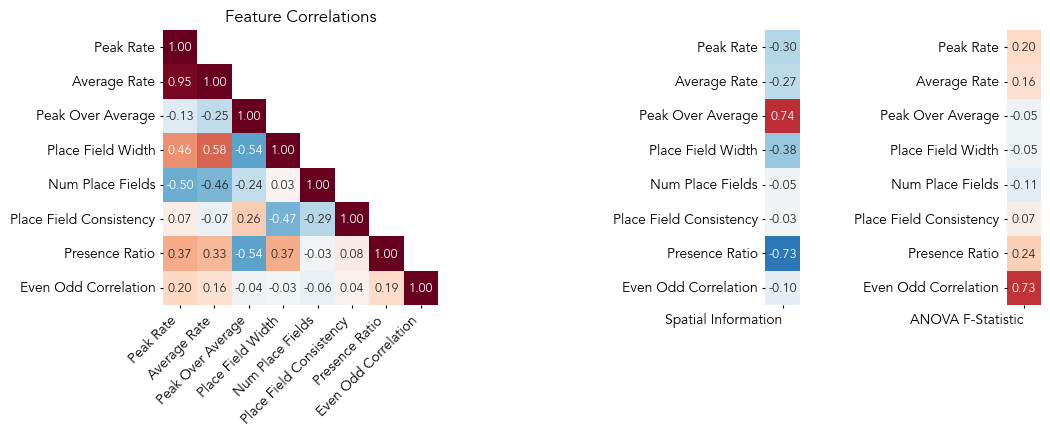

In [22]:
grid = make_grid(4, 5, wspace=1,hspace = 1,figsize=(14,5))
plt.rcParams.update({
    'font.family':  'Avenir',  
    'font.size': 9,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'legend.fontsize': 12,
    'xtick.labelsize': 10,  # Smaller tick label size
    'ytick.labelsize': 10,  # Smaller tick label size
    'axes.linewidth': 0.5,  # Reduce the thickness of axis lines
    'xtick.major.width': 0.8,  # Thinner x ticks
    'ytick.major.width': 0.8,  # Thinner y ticks
    'xtick.major.size': 2.0,   # Shorter x ticks
    'ytick.major.size': 2.0,   # Shorter y ticks
 # Smaller colorbar label font
})
feature_labels = [name.replace('_', ' ').title() for name in feature_names]

# Feature correlation matrix
ax = get_grid_subplot(grid, slice(0, 3), slice(0, 3))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(correlation_matrix, mask=mask, xticklabels=feature_labels, yticklabels=feature_labels,
            cmap='RdBu_r', vmin=-1, vmax=1, center=0, square=True, annot=True, fmt='.2f', ax=ax, cbar=False)
ax.set_title('Feature Correlations')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Place info correlations
ax = get_grid_subplot(grid,slice(0, 3) , 3)
place_info_corr = [correlations[f'{feat}_vs_place_info'] for feat in feature_names]
sns.heatmap(np.array(place_info_corr).reshape(-1,1), yticklabels=feature_labels, xticklabels=['Spatial Information'],
            cmap='RdBu_r', vmin=-1, vmax=1, center=0, square=True, annot=True, fmt='.2f', ax=ax, cbar=False)

ax.set_xticklabels(ax.get_xticklabels(),  ha='right')

# Place ANOVA correlations
ax = get_grid_subplot(grid,slice(0, 3) , 4)
place_anova_corr = [correlations[f'{feat}_vs_place_anova'] for feat in feature_names]
sns.heatmap(np.array(place_anova_corr).reshape(-1,1), yticklabels=feature_labels, xticklabels=['ANOVA F-Statistic'],
            cmap='RdBu_r', vmin=-1, vmax=1,  square=True, annot=True, fmt='.2f', ax=ax, cbar=False)

ax.set_xticklabels(ax.get_xticklabels(), ha='right')

save_figure('Correlation_Human_Estimated_Feature_vs_Method',file_path='/Users/weijiazhang/Plots/PLDM/Human',dpi=300)


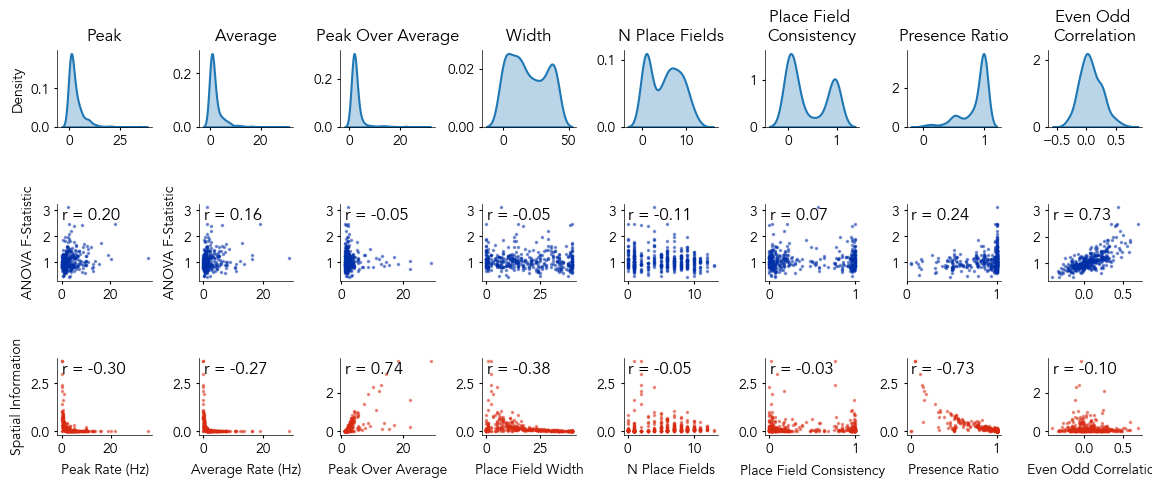

In [23]:
lw=1
ms = 1
grid = make_grid(3, 8, wspace=.5,hspace = 1,figsize=(14,5)
                 )

plt.rcParams.update({
    'font.family':  'Avenir',  
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'legend.fontsize': 12,
    'xtick.labelsize': 10,  # Smaller tick label size
    'ytick.labelsize': 10,  # Smaller tick label size
    'axes.linewidth': 0.5,  # Reduce the thickness of axis lines
    'xtick.major.width': 0.8,  # Thinner x ticks
    'ytick.major.width': 0.8,  # Thinner y ticks
    'xtick.major.size': 2.0,   # Shorter x ticks
    'ytick.major.size': 2.0,   # Shorter y ticks
 # Smaller colorbar label font
})
color_map = 'Greys'
anova_color = '#002FA7'  # Deep blue for ANOVA
info_color = '#D92911'   # Deep red for Spatial Info
SNR_color = 'darkred'

# Define variables for scatter plot parameters
s = ms
alpha = 0.5


ax = get_grid_subplot(grid, 0, 0)
sns.kdeplot(data=peak_rate, alpha=0.3, fill=True, ax=ax)
ax.set_title('Peak')
ax.set_xlabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 0)
ax.scatter(peak_rate, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 0.95, f'r = {correlations["peak_rate_vs_place_anova"]:.2f}', transform=ax.transAxes, verticalalignment='top')
ax.set_ylabel('ANOVA F-Statistic')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 0)
ax.scatter(peak_rate, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 0.95, f'r = {correlations["peak_rate_vs_place_info"]:.2f}', transform=ax.transAxes,  verticalalignment='top')
ax.set_ylabel('Spatial Information')
ax.set_xlabel('Peak Rate (Hz)')
drop_spines(['top','right'])


ax = get_grid_subplot(grid, 0, 1)
sns.kdeplot(data=average_rate, alpha=0.3, fill=True, ax=ax)
ax.set_title('Average')
ax.set_ylabel('')
ax.set_xlabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 1)
ax.scatter(average_rate, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 0.95, f'r = {correlations["average_rate_vs_place_anova"]:.2f}', transform=ax.transAxes, verticalalignment='top')
ax.set_ylabel('ANOVA F-Statistic')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 1)
ax.scatter(average_rate, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 0.95, f'r = {correlations["average_rate_vs_place_info"]:.2f}', transform=ax.transAxes, verticalalignment='top')
ax.set_xlabel('Average Rate (Hz)')
drop_spines(['top','right'])


ax = get_grid_subplot(grid, 0, 2)
sns.kdeplot(data=peak_over_average_rate, alpha=0.3, fill=True, ax=ax)
ax.set_title('Peak Over Average')
ax.set_xlabel('')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 2)
ax.scatter(peak_over_average_rate, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 0.95, f'r = {correlations["peak_over_average_vs_place_anova"]:.2f}', transform=ax.transAxes, verticalalignment='top')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 2)
ax.scatter(peak_over_average_rate, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 0.95, f'r = {correlations["peak_over_average_vs_place_info"]:.2f}', transform=ax.transAxes, verticalalignment='top')
ax.set_ylabel('')
ax.set_xlabel('Peak Over Average')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 0, 3)
sns.kdeplot(data=place_field_width, alpha=0.3, fill=True, ax=ax)
ax.set_title('Width')
ax.set_xlabel('')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 3)
ax.scatter(place_field_width, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 0.95, f'r = {correlations["place_field_width_vs_place_anova"]:.2f}', transform=ax.transAxes,  verticalalignment='top')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 3)
ax.scatter(place_field_width, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 0.95, f'r = {correlations["place_field_width_vs_place_info"]:.2f}', transform=ax.transAxes, verticalalignment='top')
ax.set_xlabel('Place Field Width')
drop_spines(['top','right'])


ax = get_grid_subplot(grid, 0, 4)
sns.kdeplot(data=num_place_fields, alpha=0.3, fill=True, ax=ax)
ax.set_title('N Place Fields')
ax.set_xlabel('')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 4)
ax.scatter(num_place_fields, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 0.95, f'r = {correlations["num_place_fields_vs_place_anova"]:.2f}', transform=ax.transAxes, verticalalignment='top')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 4)
ax.scatter(num_place_fields, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 0.95, f'r = {correlations["num_place_fields_vs_place_info"]:.2f}', transform=ax.transAxes,  verticalalignment='top')
ax.set_xlabel('N Place Fields')
ax.set_ylabel('')
drop_spines(['top','right'])


ax = get_grid_subplot(grid, 0, 5)
sns.kdeplot(data=place_field_centre_consistency, alpha=0.3, fill=True, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Place Field \nConsistency')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 5)
ax.scatter(place_field_centre_consistency, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 0.95, f'r = {correlations["place_field_consistency_vs_place_anova"]:.2f}', transform=ax.transAxes,  verticalalignment='top')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 5)
ax.scatter(place_field_centre_consistency, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 0.95, f'r = {correlations["place_field_consistency_vs_place_info"]:.2f}', transform=ax.transAxes, verticalalignment='top')
ax.set_xlabel('Place Field Consistency')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 0, 6)
sns.kdeplot(data=presence_ratio, alpha=0.3, fill=True, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Presence Ratio')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 6)
ax.scatter(presence_ratio, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 0.95, f'r = {correlations["presence_ratio_vs_place_anova"]:.2f}', transform=ax.transAxes,  verticalalignment='top')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 6)
ax.scatter(presence_ratio, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 0.95, f'r = {correlations["presence_ratio_vs_place_info"]:.2f}', transform=ax.transAxes,  verticalalignment='top')
ax.set_xlabel('Presence Ratio')
ax.set_ylabel('')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 0, 7)
sns.kdeplot(data=even_odd_corr, alpha=0.3, fill=True, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Even Odd \nCorrelation')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 1, 7)
ax.scatter(even_odd_corr, place_anova, s=s, alpha=alpha, color=anova_color)
ax.text(0.05, 0.95, f'r = {correlations["even_odd_correlation_vs_place_anova"]:.2f}', transform=ax.transAxes,  verticalalignment='top')
drop_spines(['top','right'])

ax = get_grid_subplot(grid, 2, 7)
ax.scatter(even_odd_corr, place_info, s=s, alpha=alpha, color=info_color)
ax.text(0.05, 0.95, f'r = {correlations["even_odd_correlation_vs_place_info"]:.2f}', transform=ax.transAxes, verticalalignment='top')
ax.set_xlabel('Even Odd Correlation')
ax.set_ylabel('')
drop_spines(['top','right'])

save_figure('Human_Estimated_Feature_vs_Method',file_path='/Users/weijiazhang/Plots/PLDM/Human')



In [67]:
# Save feature distributions to CSV for human data
# Create a DataFrame with all the features and metrics
features_df = pd.DataFrame({
    'peak_rate': peak_rate,
    'average_rate': average_rate,
    'peak_over_average': peak_over_average_rate,
    'place_field_width': place_field_width,
    'num_place_fields': num_place_fields,
    'place_field_centre_consistency': place_field_centre_consistency,
    'presence_ratio': presence_ratio,
    'place_info': place_info,
    'place_anova': place_anova,
})

output_path = '/Users/weijiazhang/Plots/PLDM/Human/human_place_features.csv'
features_df.to_csv(output_path, index=False)
print(f"Human features saved to {output_path}")




Human features saved to /Users/weijiazhang/Plots/PLDM/Human/human_place_features.csv
